In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
from lsst.sims.maf.plots import HealpixPowerSpectrum

In [2]:
dbFile = 'minion_1016_sqlite.db'
# This connection checks which version it thinks the database is and should do the right thing schema-wise
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [3]:
bundleList = []

metric = metrics.CountMetric(col='expMJD', units='Count', metricName='Count No Dither')
slicer = slicers.HealpixSlicer(latLonDeg=False)
sql = 'filter="r"'

bundleList.append(metricBundles.MetricBundle(metric,slicer,sql))

metric = metrics.CountMetric(col='expMJD', units='Count', metricName='Count Small Dither')
slicer = slicers.HealpixSlicer(latCol='ditheredDec', lonCol='ditheredRA', latLonDeg=False)
sql = 'filter="r"'

bundleList.append(metricBundles.MetricBundle(metric,slicer,sql))


Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


Querying database Summary with constraint filter="r" for columns ['fieldDec', 'ditheredDec', 'ditheredRA', 'fieldRA', 'expMJD']
Found 538713 visits
Running:  ['opsim_Count_No_Dither_r_HEAL']
Completed metric generation.
Running:  ['opsim_Count_Small_Dither_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter="r"" constraint now.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 967 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 190.232  dipole: lon: 55.4292, lat: -48.222, amp: 26.3642


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 726 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 178.75  dipole: lon: 63.6391, lat: -59.6017, amp: 44.3397
Plotting complete.


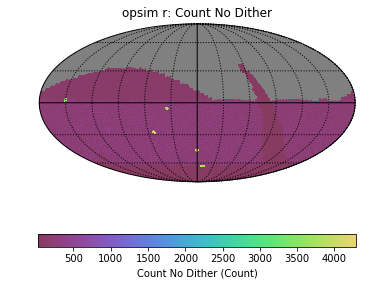

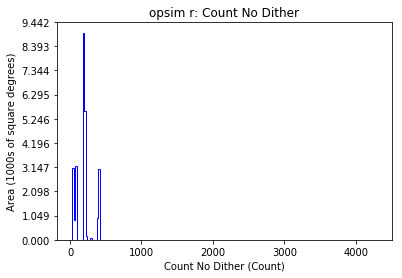

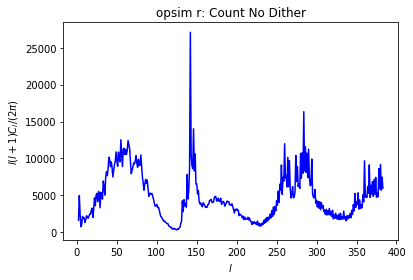

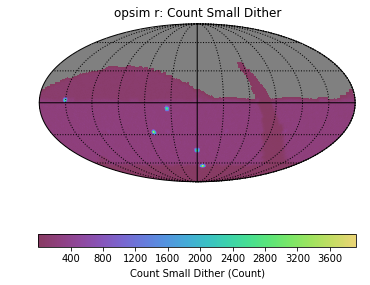

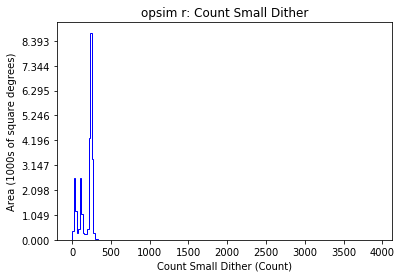

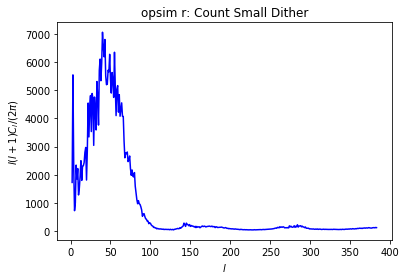

In [4]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

In [5]:
dbFile = 'alt_sched.db'
# This connection checks which version it thinks the database is and should do the right thing schema-wise
conn = db.OpsimDatabase(dbFile)

In [6]:
bundleList2 = []

metric = metrics.CountMetric(col='observationStartMJD', units='Count', metricName='Count No Dither')
slicer = slicers.HealpixSlicer(latLonDeg=True)
sql = 'filter="r"'

bundleList2.append(metricBundles.MetricBundle(metric,slicer,sql))


Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


Querying database SummaryAllProps with constraint filter="r" for columns ['fieldDec', 'observationStartMJD', 'fieldRA']
Found 570519 visits
Running:  ['opsim_Count_No_Dither_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter="r"" constraint now.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 612 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 240.41  dipole: lon: 163.735, lat: -62.3628, amp: 41.2592
Plotting complete.


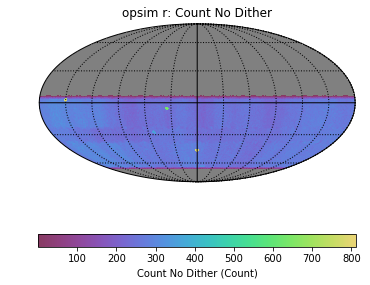

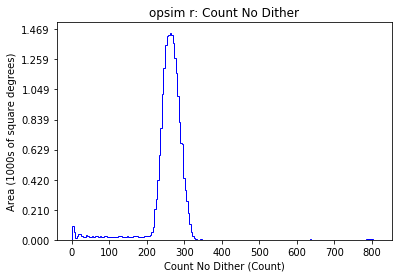

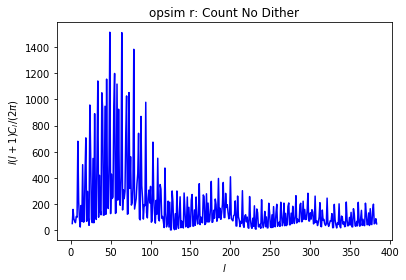

In [7]:
bd2 = metricBundles.makeBundlesDictFromList(bundleList2)
bg2 = metricBundles.MetricBundleGroup(bd2, conn, outDir=outDir, resultsDb=resultsDb)
bg2.runAll()
bg2.plotAll(closefigs=False)

In [8]:
from lsst.sims.utils import hpid2RaDec

npix = bundleList[0].metricValues.size
nside = hp.npix2nside(npix)

ra, dec = hpid2RaDec(nside, np.arange(npix))

In [9]:
subsec = np.where((dec < 0) & (dec > -60) & (ra > 300) & (ra < 350))

no_dither = bundleList[0].metricValues*0 + hp.UNSEEN
no_dither[subsec] = np.ma.masked_array(bundleList[0].metricValues[subsec])
         
small_dither = bundleList[0].metricValues*0 + hp.UNSEEN
small_dither[subsec] = np.ma.masked_array(bundleList[1].metricValues[subsec])

global_dither = bundleList2[0].metricValues*0 + hp.UNSEEN
global_dither[subsec] = np.ma.masked_array(bundleList2[0].metricValues[subsec])

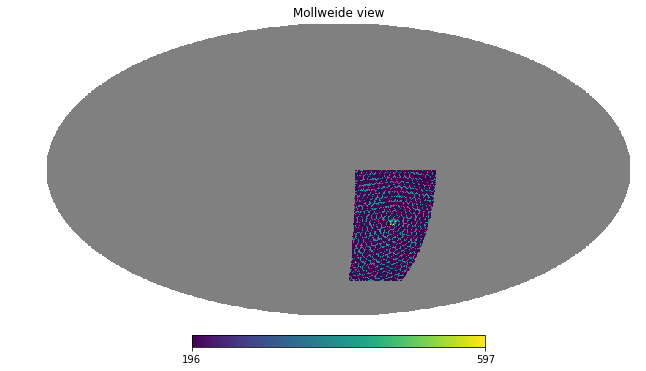

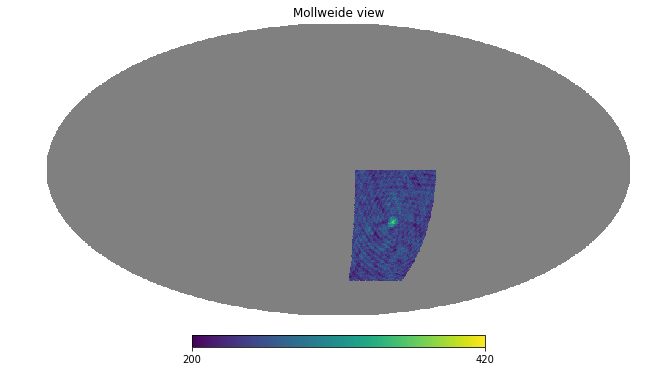

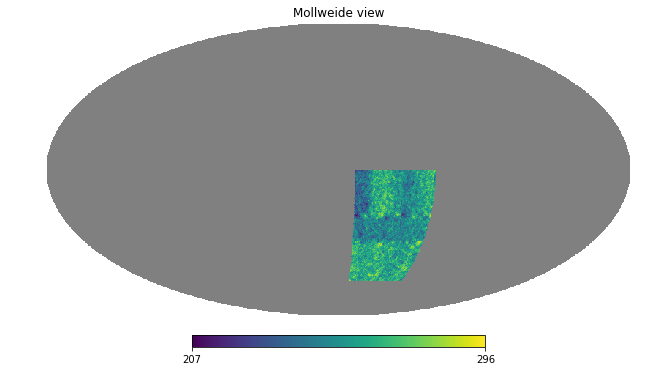

In [10]:
hp.mollview(no_dither)
hp.mollview(small_dither)
hp.mollview(global_dither)

monopole: 179  dipole: lon: -24.7494, lat: -29.6106, amp: 72.1375
monopole: 190.083  dipole: lon: -33.2808, lat: -27.0474, amp: 59.8399
monopole: 290.512  dipole: lon: 162.727, lat: 14.7939, amp: 40.8987


(0.1, 10000.0)

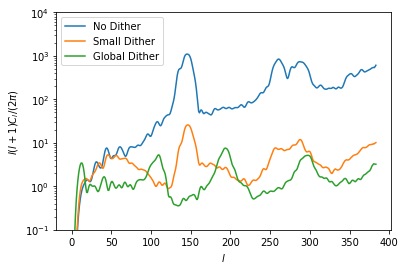

In [11]:
for inmap, label in zip([no_dither, small_dither, global_dither], ['No Dither', 'Small Dither', 'Global Dither']):
    cl = hp.anafast(hp.remove_dipole(inmap))
    ell = np.arange(np.size(cl))
    plt.semilogy(ell, (cl * ell * (ell + 1)) / 2.0 / np.pi, label=label)
plt.xlabel(r'$l$')
plt.ylabel(r'$l(l+1)C_l/(2\pi)$')
plt.legend()
plt.ylim([1e-1, 1e4])